<a href="https://colab.research.google.com/github/ianzin30/IF1014-Mining/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link dataset Nomao https://drive.google.com/drive/folders/1qnOMoNw4iNODx7e7e4-vWsPIaKi1VI4J?usp=sharing

Coloque os arquivos no mesmo nivel de sample_data

### Importando as bibliotecas que serão utilizadas ao decorrer dos códigos

In [265]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier



# CRISP_DM PHASE 2


## Carregamento dos Dados

Aqui realizamos a leitura do conjunto de dados Nomao, esse armazenado nos arquivos `.data` e `.features`.  

- O arquivo **Nomao.features** contém os nomes das colunas.
- O arquivo **Nomao.data** contém os registros que analisaremos.

Após a leitura, convertemos esses arquivos em um DataFrame do Pandas para facilitar as operações futuras.


In [266]:
import os


file_path_features = os.path.join(os.getcwd(), "Nomao.features")
with open(file_path_features, 'r') as file:
    content_features = file.read()

file_path_data = os.path.join(os.getcwd(), "Nomao.data")
with open(file_path_data, 'r') as file:
    content_data = file.read()

features = content_features.split('\n')
data = list(map(lambda x: x.split(','), content_data.split('\n')))


## Primeira Visualização do Dataset

Antes de realizar qualquer transformação, é importante visualizar os primeiros registros para entender sua estrutura.

**Alvo da observação**  
- Os tipos de dados das colunas  
- A presença de valores ausentes (`?`)  
- A existência de colunas categóricas e numéricas  

Essa etapa inicial nos ajuda a definir as melhores estratégias de tratamento dos dados!


In [267]:
# Inicializando DataFrame do Nomao
nomao_df = pd.DataFrame(data, columns=features)
nomao_df.head(5)

,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
0,0#1,1,1,1,1,1,1,s,s,?,...,0.75,0.5,n,0.999953002209,0.777777777778,0.461538463831,n,1.0,0.999999996702,+1
1,0#2,1,0.75,0.857143,0.857143,0.894737,0.947368,s,n,?,...,0.5,0.307692319155,n,0.999982921892,0.538461538462,0.4375,n,1.0,0.999999962459,+1
2,0#3,1,1,1,1,1,1,s,s,?,...,0.666666666667,0.461538463831,n,0.999992600055,0.8,0.666666686535,n,1.0,0.999999999653,+1
3,4#5,1,0.75,0.857143,0.857143,0.842105,0.833333,s,n,1,...,0.5,0.285714298487,n,0.998604948886,0.555555555556,0.384615391493,n,0.999999947284,0.999994124065,+1
4,6#7,0,0,0.25,0,0.25,0,n,n,?,...,?,?,m,?,?,?,m,1.0,?,+1


In [268]:
valor_faltante = nomao_df.isin(["?"]).any(axis=1).sum()

print(f"Número de linhas com pelo menos um valor faltante: {valor_faltante}")


Número de linhas com pelo menos um valor faltante: 34465


## 📊 Informações Gerais do Dataset

Agora vamos analisar a estrutura do DataFrame e obter estatísticas básicas.

📌 **Principais pontos analisados:**  
- Número total de linhas e colunas  
- Tipos de dados em cada coluna  

Essas informações são fundamentais para o próximo passo: o **pré-processamento**.


In [269]:
print(nomao_df.shape)

(34466, 120)


### Número de linhas e colunas
```python
# O dataset possui 34466 linhas e 120 colunas

In [270]:
nomao_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34466 entries, 0 to 34465
Columns: 120 entries, id to label
dtypes: object(120)
memory usage: 31.6+ MB


In [271]:
# Resumo estatístico das colunas numéricas (mesmo que estejam como 'object', aqui serve para uma noção inicial)
nomao_df.describe(include='all')


,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
count,34466,34465,34465,34465,34465,34465,34465,34465,34465,34465,...,34465,34465,34465,34465,34465,34465,34465,34465,34465,34465
unique,33959,27,43,3942,2211,759,929,2,2,8,...,67,102,3,7164,56,104,3,8549,9382,2
top,12142#12143,1,0,1,1,1,1,s,n,?,...,?,?,m,?,?,?,m,1.0,?,+1
freq,2,17687,8935,8730,8730,8013,8759,17687,25735,22295,...,18965,18965,18965,18965,18965,18965,18965,15555,18965,24621


### Curiosidade interessante

Observando o retorno acima, percebemos que, por exemplo, o ID não é único, algo intrigante pela natureza do dataset. Precisamos posteriormente estudar se isso pode causar problemas ou não, ou seja, se precisaremos tratar ou não.

##  Analisando o Balanceamento das Classes

A variável **label** do dataset indica se dois pontos referem-se ao mesmo local ou não.

**Por que isso importa?**  
- Se houver desbalanceamento (muitas instâncias de uma classe e poucas de outra), os modelos podem ficar **tendenciosos**.  
- Técnicas como **reponderação de classes, oversampling e undersampling** podem ser necessárias para corrigir isso.

Aqui, plotamos um gráfico para visualizar a proporção das classes no dataset.

In [272]:
# Remover linhas onde a coluna 'label' tem valores ausentes ANTES de separar X e y
nomao_df = nomao_df.dropna(subset=['label'])

# Separar a coluna-alvo corretamente agora sem valores None
label_col = nomao_df['label']

# Remover a coluna 'label' do DataFrame de features
nomao_df = nomao_df.drop(columns=['label'])

# Verificar se ainda há valores nulos
print(label_col.isnull().sum())  # Deve imprimir 0
print(label_col.unique())  # Deve mostrar apenas ['+1', '-1']


0
['+1' '-1']


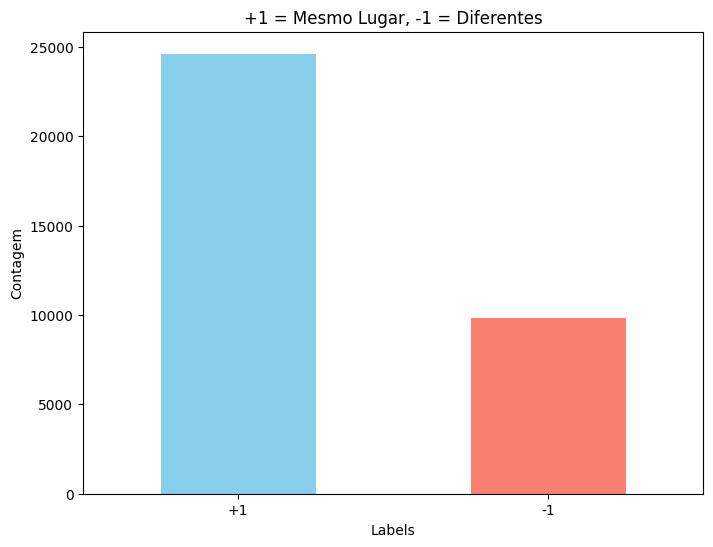

In [273]:
plt.figure(figsize=(8,6))
label_col.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('+1 = Mesmo Lugar, -1 = Diferentes')
plt.xlabel('Labels')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.show()


### Conclusão de balanceamento

É notório perceber que há uma clara quantidade maior de labels positivas do que negativas, resumindo, o modelo pode ser tendencioso para apontar que os locais são os mesmos pontos.

Essa falta de equilíbrio pode afetar a capacidade do modelo de identificar corretamente as instâncias negativas, o que pode resultar em um viés nas previsões. Para melhorar o desempenho e reduzir o viés, algumas abordagens podem ser consideradas:

1. Aplicar técnicas de balanceamento como undersampling ou oversampling.
2. Escolher nossos futuros algoritmos baseados nessa características do problema.
3. Ajustar a função de custo do modelo, atribuindo um peso maior para a classe minoritária.
4. Avaliar as métricas que utilizaremos, visto que o problema é desbalanceado e a acurácia pode não ser uma boa avaliação.


##  Separação de Variáveis Numéricas e Categóricas

Para facilitar as análises, dividimos as colunas do dataset em **numéricas** e **categóricas**.


In [274]:
# Exemplo de função que checa se a maioria dos valores são numéricos ou não
def transformar(series, threshold=0.9):
    filtragem_na = series.dropna()
    if len(filtragem_na) == 0:
        # Colunas inteiras de valores ausentes são consideradas não numéricas
        return False

    n_numeros = 0
    for val in filtragem_na:
        try:
            float(val)  # Tenta converter
            n_numeros += 1
        except ValueError:
            pass

    # Fracão de valores que foram convertidos com sucesso
    fraction = n_numeros / len(filtragem_na)

    return fraction >= threshold

# Da forma explicitada pelo autor, vamos substituir os valores '?' por NaN
nomao_df = nomao_df.replace('?', np.nan)


Colunas numéricas: 89
Colunas categóricas: 30


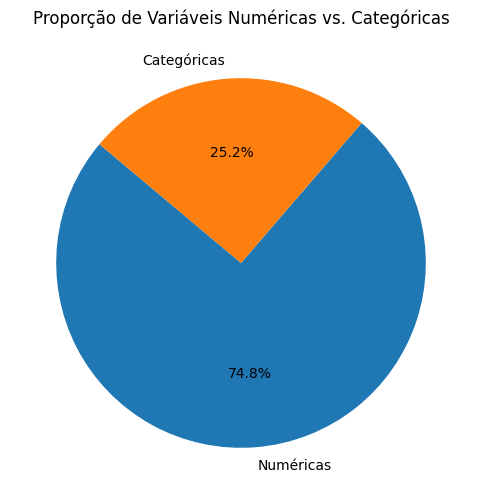

In [275]:
numericas = []
categoricas = []

for col in nomao_df.columns:
    # Se a coluna for convertível para numérico acima do threshold, convertemos
    if transformar(nomao_df[col], threshold=0.9):
        # Converter oficialmente para float (ou int) no DataFrame
        nomao_df[col] = pd.to_numeric(nomao_df[col], errors='coerce')
        numericas.append(col)
    else:
        nomao_df[col] = nomao_df[col].astype('category')
        categoricas.append(col)

print(f"Colunas numéricas: {len(numericas)}")
print(f"Colunas categóricas: {len(categoricas)}")

labels = ['Numéricas', 'Categóricas']
sizes = [len(numericas), len(categoricas)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proporção de Variáveis Numéricas vs. Categóricas')
plt.show()


### Intervalo de valores contínuos

Vamos ver como é distribuído o intervalo de valores contínuos do dataset

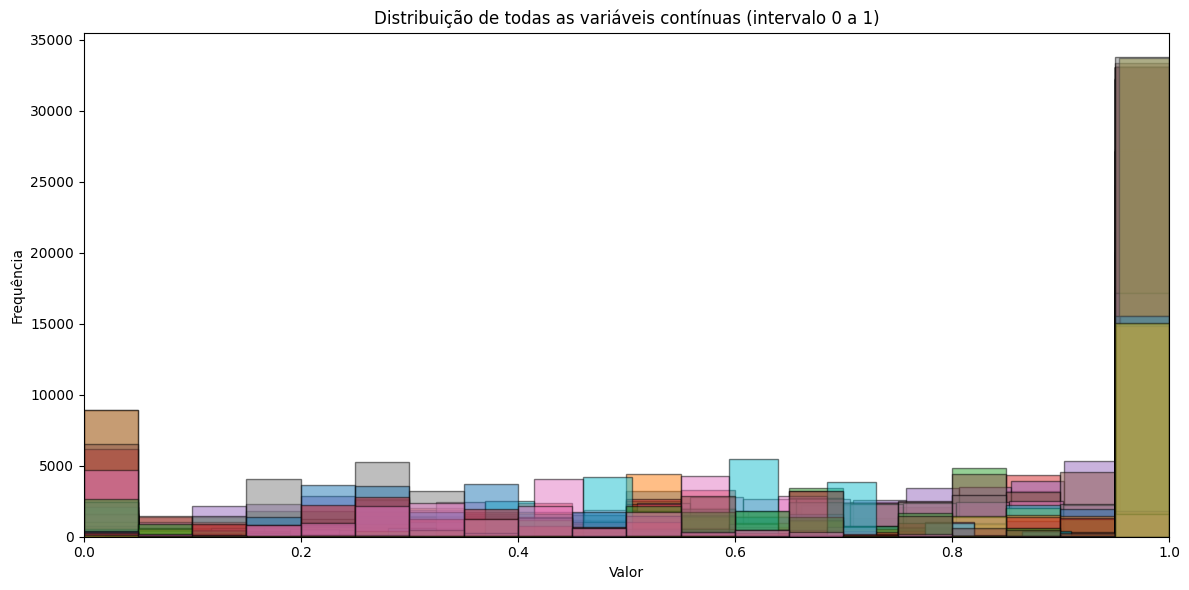

In [276]:


# Selecionando apenas as colunas numéricas contínuas
num_cols = nomao_df.select_dtypes(include=['float64', 'int64']).columns

# Plotando a distribuição das variáveis contínuas em um único histograma
plt.figure(figsize=(12, 6))

# Plotando todas as variáveis contínuas em um único gráfico
for col in num_cols:
    nomao_df[col].plot(kind='hist', bins=20, alpha=0.5, label=col, edgecolor='black')

# Configurações do gráfico
plt.title('Distribuição de todas as variáveis contínuas (intervalo 0 a 1)')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.xlim(0, 1)  # Intervalo de 0 a 1

plt.tight_layout()

# Exibindo o gráfico
plt.show()


In [277]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
def plot_group_info(values, title, xlabel, ylabel):
  def get_group_names(num_cols):
      """Cria um dicionário com nomes dos grupos e suas posições iniciais e finais."""
      grupos = defaultdict(list)

      # Criar grupos baseados no prefixo antes de "_"
      for i, nome in enumerate(num_cols):
          prefixo = nome.split("_")[0]
          grupos[prefixo].append(i)

      # Converter para um formato {nome: (pos_inicial, pos_final)}
      resultado = {k: (v[0], v[-1]) for k, v in grupos.items()}

      return resultado

  # Selecionando apenas as colunas numéricas contínuas e ordenando-as alfabeticamente
  num_cols = sorted(nomao_df.select_dtypes(include=['float64', 'int64']).columns)

  # Obter nomes dos grupos e posições no eixo X
  group_info = get_group_names(num_cols)

  # Definir cores distintas para cada grupo
  num_groups = len(group_info)
  colors = plt.cm.Paired(np.linspace(0, 1, num_groups))

  plt.figure(figsize=(12, 6))

  # Desenhando as barras com cores baseadas no grupo
  for i, (group_name, (start, end)) in enumerate(group_info.items()):
      plt.bar(range(start, end + 1), values[start:end + 1], color=colors[i], edgecolor='black')

  # Definir posições centrais dos grupos para rótulos do eixo X
  group_positions = [(start + end) / 2 for start, end in group_info.values()]

  # Aplicar nomes dos grupos no eixo X
  plt.xticks(group_positions, group_info.keys(), fontsize=10, rotation=45, ha='right')

  # Configurações do gráfico
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(0, 1)  # Assumindo que as médias estejam entre 0 e 1
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout()
  plt.show()


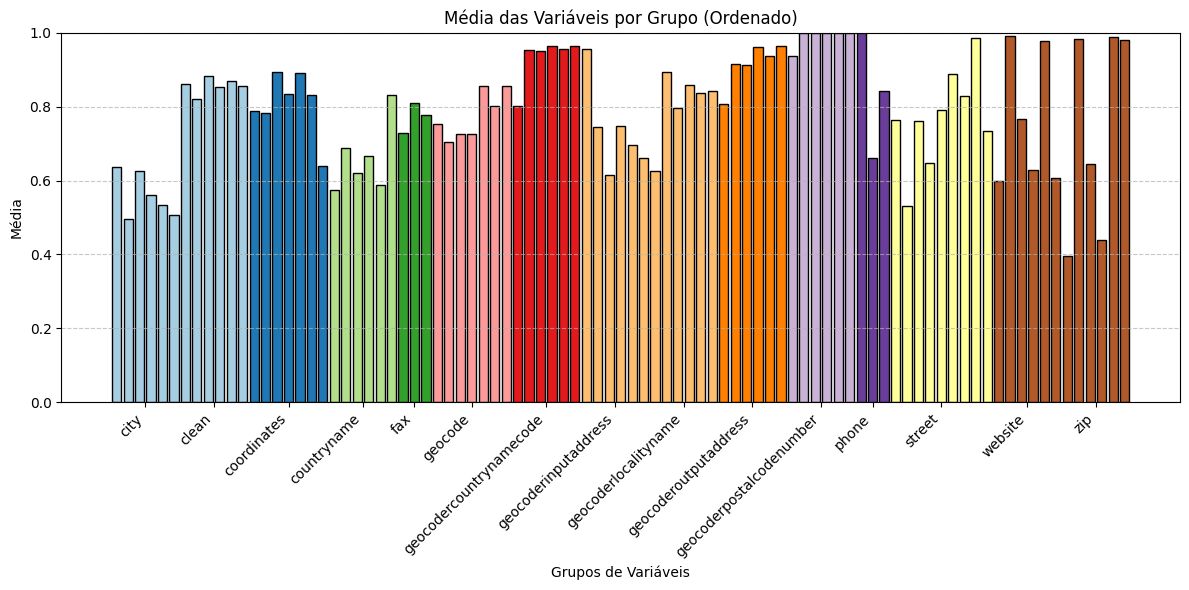

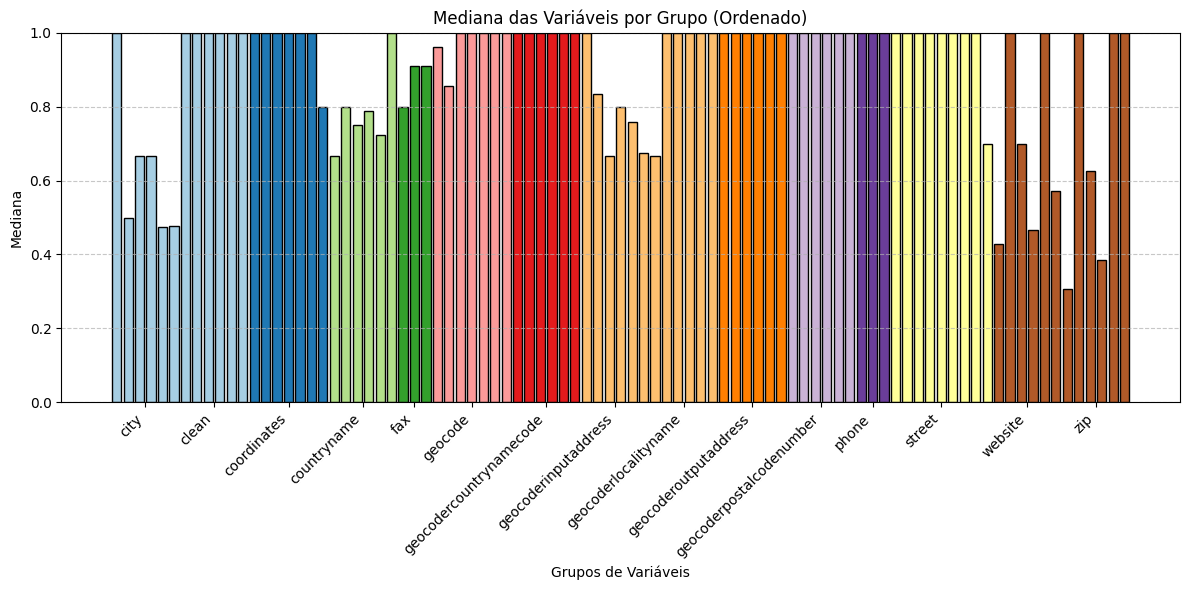

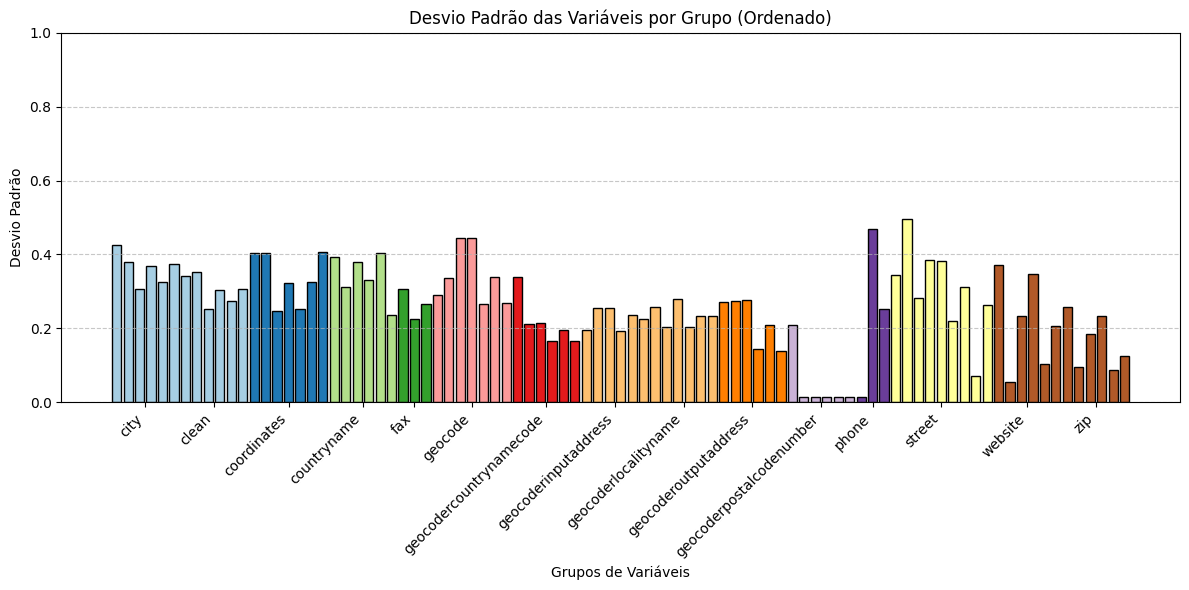

In [278]:
plot_group_info(values = nomao_df[num_cols].mean(), title = 'Média das Variáveis por Grupo (Ordenado)', xlabel = 'Grupos de Variáveis', ylabel = 'Média')
plot_group_info(values = nomao_df[num_cols].median(), title = 'Mediana das Variáveis por Grupo (Ordenado)', xlabel = 'Grupos de Variáveis', ylabel = 'Mediana')
plot_group_info(values = nomao_df[num_cols].std(), title = 'Desvio Padrão das Variáveis por Grupo (Ordenado)', xlabel = 'Grupos de Variáveis', ylabel = 'Desvio Padrão')


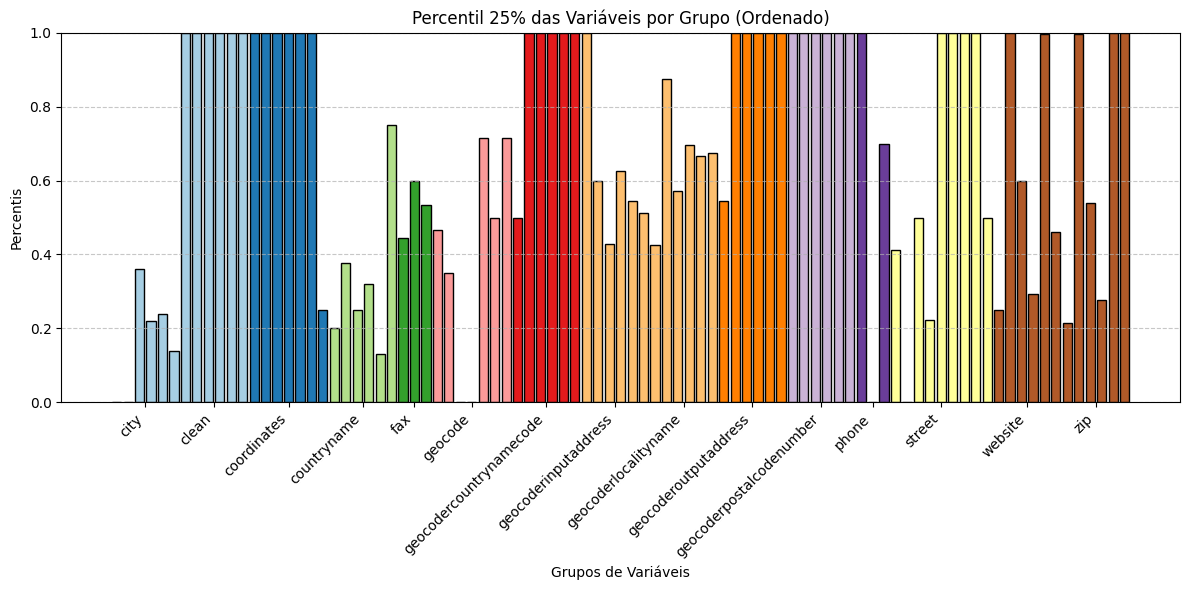

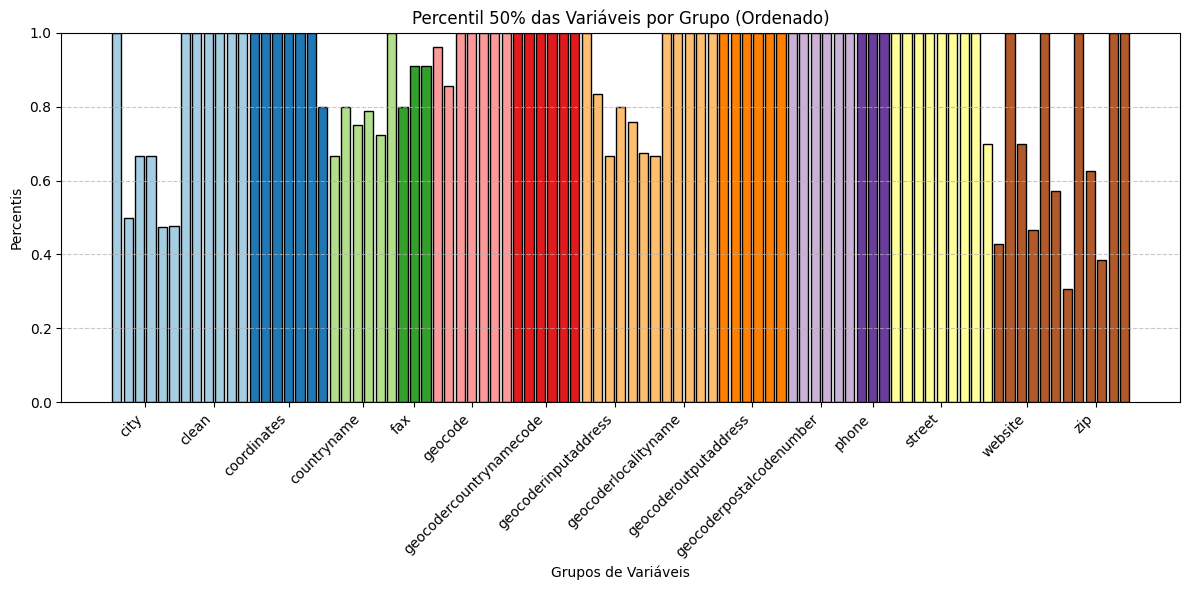

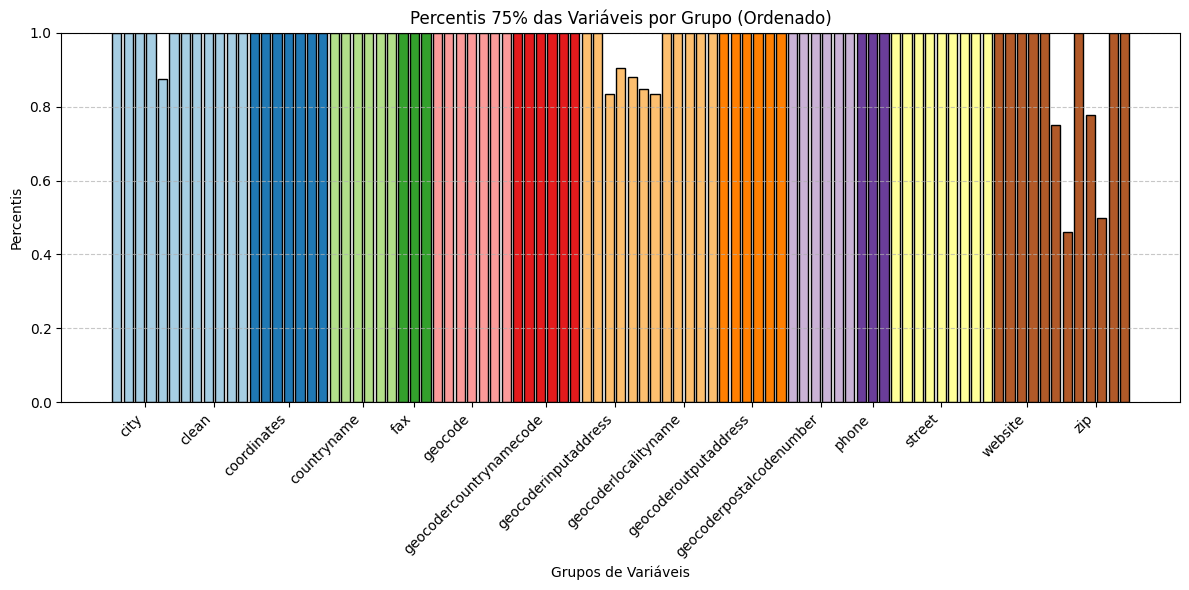

In [279]:
percentiles = nomao_df[num_cols].quantile([0.25, 0.5, 0.75])
percentiles = percentiles.T
plot_group_info(values=percentiles[0.25], title='Percentil 25% das Variáveis por Grupo (Ordenado)', xlabel='Grupos de Variáveis', ylabel='Percentis')
plot_group_info(values=percentiles[0.5], title='Percentil 50% das Variáveis por Grupo (Ordenado)', xlabel='Grupos de Variáveis', ylabel='Percentis')
plot_group_info(values=percentiles[0.75], title='Percentis 75% das Variáveis por Grupo (Ordenado)', xlabel='Grupos de Variáveis', ylabel='Percentis')

### Comentários

Aqui observamos que as colunas contínuas são distribuídas de forma que sempre ficam entre o intervalo de 0 a 1, ou seja, meio que normalizadas. O que levanta a dúvida se devemos ou não tratar os outliers que surgem de tal problema, visto que nesse caso não é de nossa expertise compreender se realmente os dados devem ser modificados, porém, segue abaixo o estudo de outliers

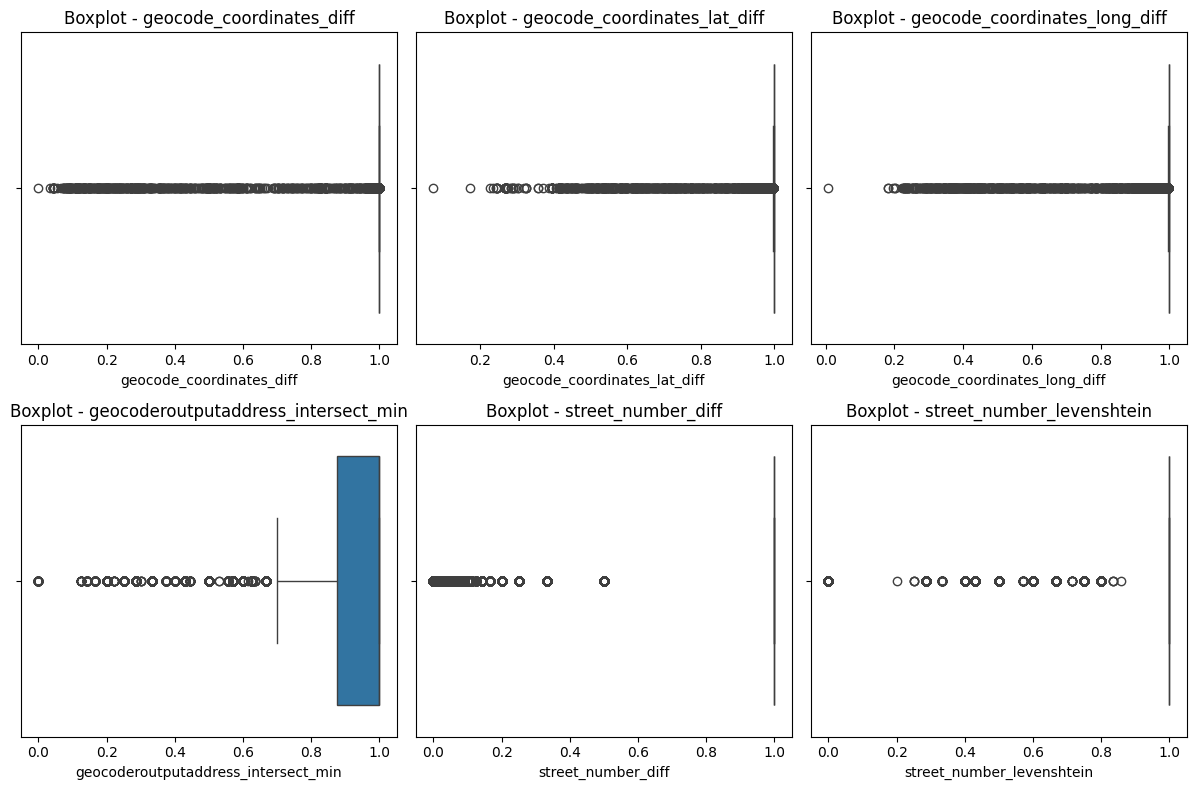

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando o número de outliers para cada coluna
Q1 = nomao_df[num_cols].quantile(0.25)
Q3 = nomao_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((nomao_df[num_cols] < (Q1 - 1.5 * IQR)) | (nomao_df[num_cols] > (Q3 + 1.5 * IQR)))

# Contando o número de outliers por coluna
outliers_count = outliers.sum()

# Selecionando as 5 colunas com mais outliers
top_6_outliers = outliers_count.nlargest(6)

# Plotando os boxplots para as 5 colunas com mais outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(top_6_outliers.index):
    plt.subplot(2, 3, i+1)  # 2 linhas, 3 colunas de subplots
    sns.boxplot(x=nomao_df[col])
    plt.title(f'Boxplot - {col}')

plt.tight_layout()
plt.show()


In [281]:
outliers = {}

for col in num_cols:
    Q1 = nomao_df[col].quantile(0.25)
    Q3 = nomao_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Encontrando os outliers
    outliers[col] = nomao_df[(nomao_df[col] < lower_bound) | (nomao_df[col] > upper_bound)].shape[0]

# Exibindo os resultados
outliers_df = pd.DataFrame(list(outliers.items()), columns=["Feature", "Outliers Count"])
outliers_df = outliers_df.sort_values(by="Outliers Count", ascending=False)

from IPython.display import display, HTML
# Tornando a exibição rolável
display(HTML(outliers_df.to_html()))


,Feature,Outliers Count
87,geocode_coordinates_diff,7517
78,geocode_coordinates_lat_diff,6495
75,geocode_coordinates_long_diff,6477
48,geocoderoutputaddress_intersect_min,5906
72,street_number_diff,5297
73,street_number_levenshtein,5297
74,street_number_trigram,5297
88,coordinates_diff,3230
55,geocoderpostalcodenumber_intersect_max,2751
56,geocoderpostalcodenumber_levenshtein_sim,2751


Observamos então que existem outliers, mas esses outliers podem ser relacionados à natureza da localização do problema, logo, resolvemos a primeira vista não considerar como problema.

## Analisando Valores Ausentes

Um aspecto crítico na preparação dos dados é lidar com valores ausentes.  
No dataset NOMAO, os valores faltantes são representados pelo símbolo **`?`**.  

**Gráfico**  
- A porcentagem de valores ausentes em cada variável  

C:\Users\iantr\AppData\Local\Temp\ipykernel_4672\1427798497.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=faltantes_porcentagem.index, y=faltantes_porcentagem.values, palette='viridis')


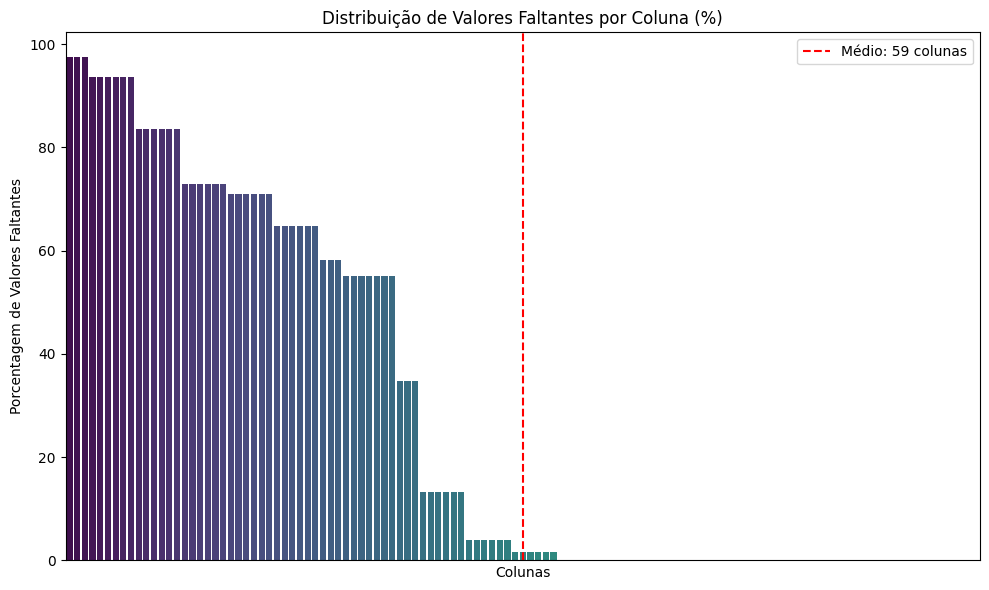

In [282]:


# Contar os valores faltantes por coluna
faltantes = nomao_df.isna().sum()

# Porcentagem de valores faltantes por coluna
faltantes_porcentagem = (faltantes / len(nomao_df)) * 100

# Ordenar as colunas por porcentagem de valores faltantes
faltantes_porcentagem = faltantes_porcentagem.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=faltantes_porcentagem.index, y=faltantes_porcentagem.values, palette='viridis')

# Escala
half_point = len(faltantes_porcentagem) // 2  # Meio do eixo x
plt.axvline(x=half_point, color='red', linestyle='--', label=f'Médio: {half_point} colunas')

# Configurações do gráfico
plt.title('Distribuição de Valores Faltantes por Coluna (%)')
plt.xlabel('Colunas')
plt.ylabel('Porcentagem de Valores Faltantes')
plt.xticks([])  # Para melhor visualização das colunas
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()


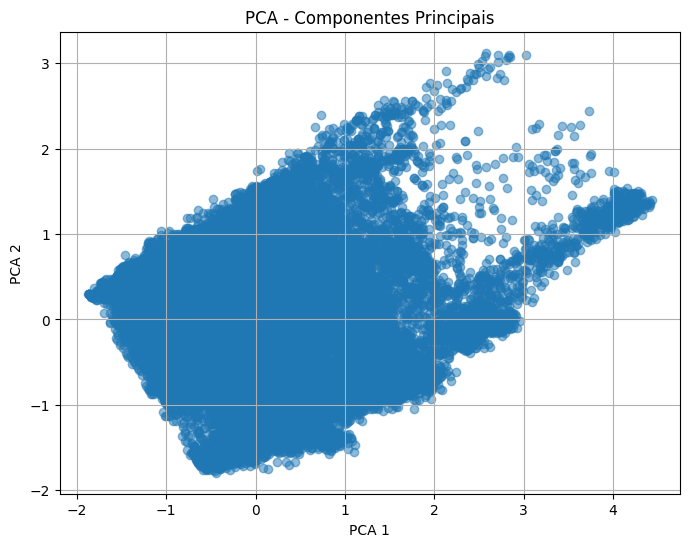

Variância explicada pelos componentes principais: [0.32373804 0.18042697]


In [283]:
# Selecionando apenas as colunas numéricas
num_cols = nomao_df.select_dtypes(include=['float64', 'int64']).columns

# Tratando valores ausentes (substituindo por média ou mediana)
nomao_df[num_cols] = nomao_df[num_cols].fillna(nomao_df[num_cols].mean())  # ou use mediana em vez de média

# Aplicando PCA
pca = PCA(n_components=2)  # Reduzindo para 2 componentes principais para visualização
pca_result = pca.fit_transform(nomao_df[num_cols])

# Criando um DataFrame com os componentes principais
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Plotando os resultados do PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], alpha=0.5)
plt.title('PCA - Componentes Principais')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# Verificando a variância explicada
explained_variance = pca.explained_variance_ratio_
print(f"Variância explicada pelos componentes principais: {explained_variance}")


c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


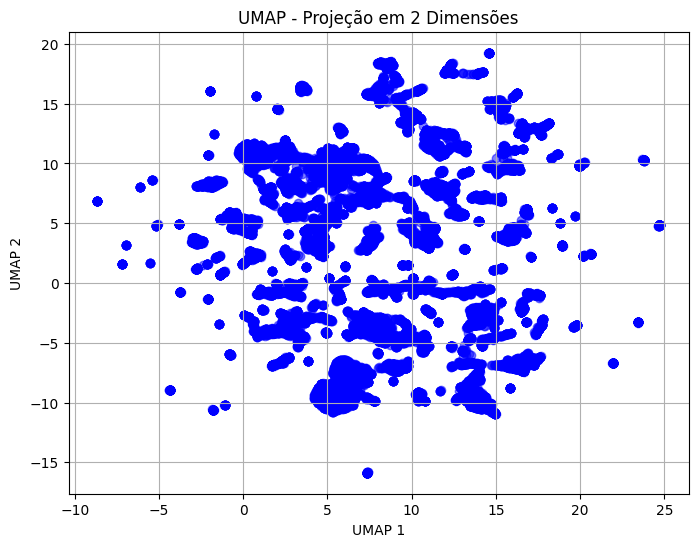

In [284]:
# Aplicando UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduzindo para 2 componentes
umap_result = umap_model.fit_transform(nomao_df[num_cols])

# Criando um DataFrame com os componentes UMAP
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])

# Plotando os resultados do UMAP
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.5, c='blue')
plt.title('UMAP - Projeção em 2 Dimensões')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


## Outliers

## Conclusões da Análise Exploratória

Após explorar o conjunto de dados, podemos concluir que:  

O dataset possui **120** variáveis e **34.466** registros.  
Existe um grande número de colunas ausentes.  
Detectamos que os valores contínuos são divididos em um intervalo de 0 a 1, o que pode configurar uma normalização.
O desbalanceamento sugere a necessidade de ajustes no treinamento dos modelos.


# CRISP_DM PHASE 3

## Transformar colunas categoricas
Transformar colunas categoricas em dummies, com valores numericos. (n, s, m) => (0,1,2)


In [285]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = nomao_df
y = label_col              # Coluna-alvo

# Dividindo o dataset em treino (80%) e teste (20%), mantendo a consistência das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=0.8,      
    random_state=42,      
    stratify=y            
)

print("Tamanho do treino:", X_train.shape[0])
print("Tamanho do teste :", X_test.shape[0])

X_train = X_train.drop(columns=['id'], errors='ignore')
X_test = X_test.drop(columns=['id'], errors='ignore')

train_df = pd.concat([X_train, y_train], axis=1)

test_df = pd.concat([X_test, y_test], axis=1)


Tamanho do treino: 27572
Tamanho do teste : 6893


In [286]:

# 2) Selecionar colunas numéricas e preencher valores faltantes com -1
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
train_df[numeric_cols] = train_df[numeric_cols].fillna(-1)


In [287]:
# Replicar para o conjunto de teste ( não é um problema nesse caso também, pois não é estatístico)
numeric_colunas = test_df.select_dtypes(include=[np.number]).columns
test_df[numeric_colunas] = test_df[numeric_colunas].fillna(-1)

In [288]:
missing_numeric = train_df[numeric_cols].isnull().sum()
print("Valores faltantes em colunas numéricas (treino):\n", missing_numeric)
print("Total faltante numérico (treino):", missing_numeric.sum())


Valores faltantes em colunas numéricas (treino):
 clean_name_intersect_min       0
clean_name_intersect_max       0
clean_name_levenshtein_sim     0
clean_name_trigram_sim         0
clean_name_levenshtein_term    0
                              ..
coordinates_lat_diff           0
coordinates_lat_levenshtein    0
coordinates_lat_trigram        0
geocode_coordinates_diff       0
coordinates_diff               0
Length: 89, dtype: int64
Total faltante numérico (treino): 0


In [289]:
missing_numeric = test_df[numeric_colunas].isnull().sum()
print("Valores faltantes em colunas numéricas (teste):\n", missing_numeric)
print("Total faltante numérico (teste):", missing_numeric.sum())

Valores faltantes em colunas numéricas (teste):
 clean_name_intersect_min       0
clean_name_intersect_max       0
clean_name_levenshtein_sim     0
clean_name_trigram_sim         0
clean_name_levenshtein_term    0
                              ..
coordinates_lat_diff           0
coordinates_lat_levenshtein    0
coordinates_lat_trigram        0
geocode_coordinates_diff       0
coordinates_diff               0
Length: 89, dtype: int64
Total faltante numérico (teste): 0


In [290]:
cat_cols = train_df.select_dtypes(include=['category']).columns
print("Colunas categóricas identificadas:", list(cat_cols))


Colunas categóricas identificadas: ['clean_name_including', 'clean_name_equality', 'city_including', 'city_equality', 'zip_including', 'zip_equality', 'street_including', 'street_equality', 'website_including', 'website_equality', 'countryname_including', 'countryname_equality', 'geocoderlocalityname_including', 'geocoderlocalityname_equality', 'geocoderinputaddress_including', 'geocoderinputaddress_equality', 'geocoderoutputaddress_including', 'geocoderoutputaddress_equality', 'geocoderpostalcodenumber_including', 'geocoderpostalcodenumber_equality', 'geocodercountrynamecode_including', 'geocodercountrynamecode_equality', 'phone_equality', 'fax_equality', 'street_number_equality', 'geocode_coordinates_long_equality', 'geocode_coordinates_lat_equality', 'coordinates_long_equality', 'coordinates_lat_equality']


In [291]:
import pandas as pd

# Selecionar colunas categóricas corretamente (as que não são numéricas de fato)
cat_cols = train_df.select_dtypes(include=['category']).columns

# Garantir que há colunas categóricas antes de aplicar One-Hot Encoding
if len(cat_cols) > 0:
    # Aplicar One-Hot Encoding
    train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
    train_df = train_df.astype('float64')  # Garantir que os tipos são float
    print("One-Hot Encoding aplicado com sucesso!")
    print("Novas colunas criadas:", list(train_df.columns))
else:
    print("Nenhuma coluna categórica encontrada para One-Hot Encoding.")

# Conferir se ainda há valores nulos após a transformação
missing_data_cat = train_df.isnull().sum()
total_missing_cat = missing_data_cat.sum()
print("Valores faltantes após One-Hot Encoding:\n", missing_data_cat[missing_data_cat > 0])
print("Total faltante categórico (treino):", total_missing_cat)


One-Hot Encoding aplicado com sucesso!
Novas colunas criadas: ['clean_name_intersect_min', 'clean_name_intersect_max', 'clean_name_levenshtein_sim', 'clean_name_trigram_sim', 'clean_name_levenshtein_term', 'clean_name_trigram_term', 'city_intersect_min', 'city_intersect_max', 'city_levenshtein_sim', 'city_trigram_sim', 'city_levenshtein_term', 'city_trigram_term', 'zip_intersect_min', 'zip_intersect_max', 'zip_levenshtein_sim', 'zip_trigram_sim', 'zip_levenshtein_term', 'zip_trigram_term', 'street_intersect_min', 'street_intersect_max', 'street_levenshtein_sim', 'street_trigram_sim', 'street_levenshtein_term', 'street_trigram_term', 'website_intersect_min', 'website_intersect_max', 'website_levenshtein_sim', 'website_trigram_sim', 'website_levenshtein_term', 'website_trigram_term', 'countryname_intersect_min', 'countryname_intersect_max', 'countryname_levenshtein_sim', 'countryname_trigram_sim', 'countryname_levenshtein_term', 'countryname_trigram_term', 'geocoderlocalityname_intersect

In [292]:

# Selecionar colunas categóricas corretamente (as que não são numéricas de fato)
cat_cols_test = test_df.select_dtypes(include=['category']).columns

# Garantir que há colunas categóricas antes de aplicar One-Hot Encoding
if len(cat_cols_test) > 0:
    # Aplicar One-Hot Encoding
    # 4) Aplicar get_dummies no test_df
    test_df = pd.get_dummies(test_df, columns=cat_cols_test, drop_first=True)
    test_df = test_df.astype('float64')  # Garantir que os tipos são float
    print("One-Hot Encoding aplicado com sucesso!")
    test_df = test_df.reindex(columns=train_df.columns, fill_value=0)  # Garantir que as colunas são as mesmas
else:
    print("Nenhuma coluna categórica encontrada para One-Hot Encoding.")

# Conferir se ainda há valores nulos após a transformação
missing_data_cat = test_df.isnull().sum()
total_missing_cat = missing_data_cat.sum()
print("Valores faltantes após One-Hot Encoding:\n", missing_data_cat[missing_data_cat > 0])
print("Total faltante categórico (teste):", total_missing_cat)

One-Hot Encoding aplicado com sucesso!
Valores faltantes após One-Hot Encoding:
 Series([], dtype: int64)
Total faltante categórico (teste): 0


In [293]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Arquivos 'train.csv' e 'test.csv' salvos com sucesso!")

Arquivos 'train.csv' e 'test.csv' salvos com sucesso!


In [294]:
X_train = train_df.drop('label', axis=1)
X_test = test_df.drop('label', axis=1)



## Desbalanceamento

Utilizando SMOTE para suprir a diferença de classes

In [295]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

ImportError: cannot import name 'tarfile_extractall' from 'sklearn.utils.fixes' (c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\fixes.py)

In [ ]:
# Definindo os hiperparâmetros para o KNN utilizando range
param_dist_knn = {
    'n_neighbors': list(range(1, 31)),  # Testa de 1 a 30 vizinhos
    'weights': ['uniform', 'distance'],
    'p': list(range(1, 3))  # p=1 para Manhattan e p=2 para Euclidiana
}

# Instanciando o classificador KNN
knn = KNeighborsClassifier()

# Usando a mesma estratégia de validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurando o RandomizedSearchCV para o KNN
knn_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist_knn,
    n_iter=20,                   # 20 iterações conforme solicitado
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Ajustando o modelo KNN com os dados de treino
knn_search.fit(X_train, y_train)

print("Melhores hiperparâmetros KNN:", knn_search.best_params_)
print("Melhor pontuação KNN:", knn_search.best_score_)

# Recupera o melhor estimador treinado para KNN
best_knn = knn_search.best_estimator_



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros KNN: {'weights': 'distance', 'p': 1, 'n_neighbors': 19}
Melhor pontuação KNN: 0.9481698371250269


In [ ]:
X_test

,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,city_intersect_min,city_intersect_max,city_levenshtein_sim,city_trigram_sim,...,street_number_equality_n,street_number_equality_s,geocode_coordinates_long_equality_n,geocode_coordinates_long_equality_s,geocode_coordinates_lat_equality_n,geocode_coordinates_lat_equality_s,coordinates_long_equality_n,coordinates_long_equality_s,coordinates_lat_equality_n,coordinates_lat_equality_s
8344,1.0,0.333333,0.500000,0.500000,0.200000,0.225000,0.860946,0.82159,0.883386,0.854119,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34415,0.5,0.250000,0.370370,0.333333,0.387097,0.297297,1.000000,1.00000,1.000000,1.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
25176,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.860946,0.82159,0.883386,0.854119,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
33922,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.860946,0.82159,0.883386,0.854119,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12167,0.0,0.000000,0.183333,0.000000,0.190476,0.000000,0.860946,0.82159,0.883386,0.854119,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0.0,0.000000,0.261905,0.041667,0.217391,0.032258,1.000000,1.00000,1.000000,1.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1656,1.0,0.833333,0.909091,0.909091,0.765957,0.770833,0.860946,0.82159,0.883386,0.854119,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12466,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
26004,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.860946,0.82159,0.883386,0.854119,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Célula: Avaliação do melhor modelo KNN no conjunto de teste
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Realizando predições no conjunto de teste com o melhor KNN
y_pred_knn = best_knn.predict(X_test)

# Calculando as métricas de avaliação
print("Acurácia KNN:", accuracy_score(y_test, y_pred_knn))
print("Precisão KNN:", precision_score(y_test, y_pred_knn, average='macro'))
print("Recall KNN:", recall_score(y_test, y_pred_knn, average='macro'))
print("F1-Score KNN:", f1_score(y_test, y_pred_knn, average='macro'))
print("Matriz de Confusão KNN:\n", confusion_matrix(y_test, y_pred_knn))


Acurácia KNN: 0.9551719135354708
Precisão KNN: 0.9444321085884286
Recall KNN: 0.9459165810930512
F1-Score KNN: 0.9451701632533311
Matriz de Confusão KNN:
 [[4764  160]
 [ 149 1820]]


In [ ]:
from sklearn.metrics import accuracy_score

# Predição no conjunto de treino
y_train_pred = best_knn.predict(X_train)
acuracia_treino = accuracy_score(y_train, y_train_pred)
print("Acurácia no Treinamento:", acuracia_treino)

# Predição no conjunto de teste
y_test_pred = best_knn.predict(X_test)
acuracia_teste = accuracy_score(y_test, y_test_pred)
print("Acurácia no Teste:", acuracia_teste)


Acurácia no Treinamento: 0.9999637313216306
Acurácia no Teste: 0.9551719135354708


In [ ]:

cv_results_knn_df = pd.DataFrame(knn_search.cv_results_)
cv_results_knn_df.head()


In [ ]:
cv_results_knn_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    cv_results_knn_df['param_max_depth'], 
    cv_results_knn_df['mean_test_score']
)
plt.xlabel('max_depth')
plt.ylabel('F1 (média nos folds)')
plt.title('Evolução do Score em função do max_depth')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Espaço de hiperparâmetros com ranges maiores
param_dist_rf = {
    'n_estimators': range(50, 151, 50),            # 50, 100, 150
    'max_depth': [None] + list(range(5, 26, 5)),   # None, 5, 10, 15, 20, 25
    'min_samples_split': range(2, 5),             # 2 até 4
    'min_samples_leaf': range(1, 5),               # 1 até 4
    'bootstrap': [True, False]                     # Usar ou não amostragem bootstrap
}


In [ ]:
# Instancia o modelo base
rf = RandomForestClassifier(random_state=42)

# Configurando o RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=50,                  # número de combinações aleatórias a avaliar
    scoring='f1_macro',         # métrica principal (pode usar 'accuracy', 'recall', etc.)
    cv=cv,
    random_state=42,
    n_jobs=-1,                  # usa todos os núcleos de CPU
    verbose=1
)

# Ajusta no conjunto de treino
rf_search.fit(X_train, y_train)

# Exibe os melhores hiperparâmetros e a melhor pontuação média de cross-validation
print("Melhores hiperparâmetros (Random Forest):", rf_search.best_params_)
print("Melhor pontuação (F1 Macro):", rf_search.best_score_)

# Recupera o melhor modelo encontrado
best_rf = rf_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores hiperparâmetros (Random Forest): {'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Melhor pontuação (F1 Macro): 0.9614208126063838


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predição no conjunto de treino
y_train_pred = best_rf.predict(X_train)

print("Acurácia (Treino):", accuracy_score(y_train, y_train_pred))
print("Precisão (Treino):", precision_score(y_train, y_train_pred, average='macro'))
print("Recall (Treino):", recall_score(y_train, y_train_pred, average='macro'))
print("F1 (Treino):", f1_score(y_train, y_train_pred, average='macro'))


Acurácia (Treino): 0.996880893660235
Precisão (Treino): 0.9958049027577518
Recall (Treino): 0.9965593793591966
F1 (Treino): 0.9961812125135672


In [ ]:
from sklearn.metrics import confusion_matrix

# Predição no conjunto de teste
y_test_pred = best_rf.predict(X_test)

print("Acurácia (Teste):", accuracy_score(y_test, y_test_pred))
print("Precisão (Teste):", precision_score(y_test, y_test_pred, average='macro'))
print("Recall (Teste):", recall_score(y_test, y_test_pred, average='macro'))
print("F1 (Teste):", f1_score(y_test, y_test_pred, average='macro'))
print("Matriz de Confusão (Teste):\n", confusion_matrix(y_test, y_test_pred))


Acurácia (Teste): 0.9673581894675758
Precisão (Teste): 0.9607207797382313
Recall (Teste): 0.959170400756816
F1 (Teste): 0.9599412836347736
Matriz de Confusão (Teste):
 [[4817  107]
 [ 118 1851]]


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Faz predições no conjunto de treino e teste, 
    imprime métricas de classificação e retorna as predições.
    """
    # Predição no conjunto de treino
    y_train_pred = model.predict(X_train)
    print("==== MÉTRICAS NO TREINO ====")
    print("Acurácia (Treino):", accuracy_score(y_train, y_train_pred))
    print("Precisão (Treino):", precision_score(y_train, y_train_pred, average='macro'))
    print("Recall (Treino):", recall_score(y_train, y_train_pred, average='macro'))
    print("F1 (Treino):", f1_score(y_train, y_train_pred, average='macro'))
    print()

    # Predição no conjunto de teste
    y_test_pred = model.predict(X_test)
    print("==== MÉTRICAS NO TESTE ====")
    print("Acurácia (Teste):", accuracy_score(y_test, y_test_pred))
    print("Precisão (Teste):", precision_score(y_test, y_test_pred, average='macro'))
    print("Recall (Teste):", recall_score(y_test, y_test_pred, average='macro'))
    print("F1 (Teste):", f1_score(y_test, y_test_pred, average='macro'))
    print("Matriz de Confusão (Teste):\n", confusion_matrix(y_test, y_test_pred))

    return y_train_pred, y_test_pred


In [ ]:

from sklearn.svm import SVC


# 1) Espaço de hiperparâmetros para RandomizedSearchCV
param_grid_svm = {
    'C': list(range(1, 10)),  # Valores de 1 a 10
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1],  # 100 valores entre 0.001 e 1
}
# 2) Instancia o modelo base
svm = SVC(probability=True, random_state=42)

# 3) Configura a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) Instancia o RandomizedSearchCV
random_search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid_svm,
    n_iter=20,               # Número de combinações aleatórias a avaliar
    scoring='f1_macro',      # Métrica (ajuste conforme necessário)
    cv=cv,
    n_jobs=-1,               # Paralelizar em todos os núcleos
    random_state=42,
    verbose=1
)

# 5) Ajusta no conjunto de treino
random_search_svm.fit(X_train, y_train)

# 6) Exibe os melhores hiperparâmetros e pontuação
print("Melhores hiperparâmetros SVM:", random_search_svm.best_params_)
print("Melhor pontuação SVM (F1 Macro):", random_search_svm.best_score_)

# 7) Recupera o melhor modelo
best_svm = random_search_svm.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
evaluate_model(best_svm, X_train, y_train, X_test, y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 1) Definindo o espaço de hiperparâmetros para a Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Algoritmo de cálculo de impureza
    'max_depth': range(1, 21),                     # Profundidade entre 1 e 20 (ou None)
    'min_samples_split': range(2, 11),             # Mínimo de amostras para dividir (2 a 10)
    'min_samples_leaf': range(1, 11)               # Mínimo de amostras por folha (1 a 10)
}

# 2) Instancia o modelo base
dt = DecisionTreeClassifier(random_state=42)

# 3) Configura a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) RandomizedSearchCV para a Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist_dt,
    n_iter=20,                # Número de combinações aleatórias
    scoring='f1_macro',       # Métrica (pode ajustar para 'accuracy', etc.)
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 5) Ajusta o modelo com os dados de treino
random_search_dt.fit(X_train, y_train)

# 6) Imprime os melhores hiperparâmetros e a melhor pontuação de cross-validation
print("Melhores hiperparâmetros Decision Tree:", random_search_dt.best_params_)
print("Melhor pontuação (F1 Macro):", random_search_dt.best_score_)

# 7) Recupera o melhor estimador
best_dt = random_search_dt.best_estimator_



In [ ]:
# 9) Avalia o melhor modelo de Decision Tree
evaluate_model(best_dt, X_train, y_train, X_test, y_test)

In [ ]:
# Exemplo com random_search_dt (RandomizedSearchCV para Decision Tree)
cv_results_df = pd.DataFrame(random_search_dt.cv_results_)
cv_results_df.head()


In [ ]:
cv_results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    cv_results_df['param_max_depth'], 
    cv_results_df['mean_test_score']
)
plt.xlabel('max_depth')
plt.ylabel('F1 (média nos folds)')
plt.title('Evolução do Score em função do max_depth')
plt.show()
